In [ ]:
%load_ext autoreload
%autoreload 2

# Imports


In [1]:
import ast
import math
import os
from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torchaudio.transforms as T
from IPython.display import Audio
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

from spec_mamba import *

%matplotlib inline

In [2]:
plt.rcParams.update({"font.size": 12})
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((4, 4))

np.random.seed(42)

In [3]:
create_paths()

# Waveform data


In [2]:
gf_dataframe_origin = get_GardenFiles23_df(WAVEFORMS_DIR)
gf_dataframe_origin

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,pressureMax,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label
0,test,_2024_05_16_18_05_10,GardenFiles23/GardenFiles23_50/0/er_file_2024_...,0.365511,0.23,0.951506,0.5,0.136662,0.21,20240516,...,999.73,16.0,3.5,0.5,19.6,79.6,181.0,1.0,130.5,"Chirp, tweet"
1,test,_2024_05_16_18_05_13,GardenFiles23/GardenFiles23_50/0/er_file_2024_...,0.563732,0.23,0.943251,0.5,0.129042,0.21,20240516,...,999.73,16.0,3.5,0.5,19.6,79.6,181.0,1.0,130.5,"Chirp, tweet"
2,test,_2024_05_16_18_05_17,GardenFiles23/GardenFiles23_50/0/er_file_2024_...,0.437127,0.23,0.915113,0.5,0.240500,0.21,20240516,...,999.73,16.0,3.5,0.5,19.6,79.6,181.0,1.0,130.5,"Chirp, tweet"
3,test,_2024_05_16_18_05_20,GardenFiles23/GardenFiles23_50/0/er_file_2024_...,0.386829,0.23,0.883623,0.5,0.250826,0.21,20240516,...,999.73,16.0,3.5,0.5,19.6,79.6,181.0,1.0,130.5,Bird
4,test,_2024_05_16_18_05_25,GardenFiles23/GardenFiles23_50/0/er_file_2024_...,0.363974,0.23,0.938619,0.5,0.192257,0.21,20240516,...,999.73,16.0,3.5,0.5,19.6,79.6,181.0,1.0,130.5,"Chirp, tweet"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746186,test,_2024_06_16_12_16_34,GardenFiles23/GardenFiles23_60/99/er_file_2024...,0.187130,0.22,0.866029,0.5,0.138281,0.23,20240616,...,1000.81,13.3,9.3,3.1,13.7,97.0,211.0,3.0,391.7,"Chirp, tweet"
746187,test,_2024_06_16_12_16_43,GardenFiles23/GardenFiles23_60/99/er_file_2024...,0.520220,0.22,0.889892,0.5,0.181354,0.23,20240616,...,1000.81,13.3,9.3,3.1,13.7,97.0,211.0,3.0,391.7,Bird
746188,test,_2024_06_16_12_16_46,GardenFiles23/GardenFiles23_60/99/er_file_2024...,0.463252,0.22,0.912829,0.5,0.137533,0.23,20240616,...,1000.81,13.3,9.3,3.1,13.7,97.0,211.0,3.0,391.7,"Chirp, tweet"
746189,test,_2024_06_16_12_16_49,GardenFiles23/GardenFiles23_60/99/er_file_2024...,0.519059,0.22,0.916655,0.5,0.107621,0.23,20240616,...,1000.81,13.3,9.3,3.1,13.7,97.0,211.0,3.0,391.7,"Chirp, tweet"


In [3]:
wav_dataframe = clean_dataframe(gf_dataframe_origin)
len(wav_dataframe)

746147

In [4]:
wav_dataframe["time"].min(), wav_dataframe["time"].max(),

('_2023_08_11_17_59_32', '_2024_09_01_9_58_37')

## Foundation split


In [ ]:
wav_dataframe_train, wav_dataframe_val, wav_dataframe_test = train_val_test_split(
    wav_dataframe, train_size=0.9, val_size=0.05
)
print(
    f"train: {len(wav_dataframe_train)} - val: {len(wav_dataframe_val)} - test: {len(wav_dataframe_test)}"
)

wav_dataframe_train.to_csv(
    os.path.join(WAV_FOUNDATION_SPLITS_DIR, "train.csv"), index=False
)
wav_dataframe_val.to_csv(
    os.path.join(WAV_FOUNDATION_SPLITS_DIR, "val.csv"), index=False
)
wav_dataframe_test.to_csv(
    os.path.join(WAV_FOUNDATION_SPLITS_DIR, "test.csv"), index=False
)

## Waveform analysis


In [ ]:
sample = wav_dataframe[
    wav_dataframe["MIT_AST_label"] == "Heart sounds, heartbeat"
].sample(1)
waveform, sr = torchaudio.load("dataset/waveforms/" + sample["filename"].iloc[0])
Audio(waveform.numpy(), rate=sr)

In [5]:
SAMPLE_RATE = 48_000

In [7]:
wav_processor = WavProcessor(
    WAVEFORMS_LOCATION, wav_dataframe, sample_rate=SAMPLE_RATE, add_channels=False
)
wav_dataframe = wav_processor.dataframe
len(wav_dataframe)

746147

In [ ]:
sample_idx = wav_dataframe[wav_dataframe["MIT_AST_label"] == "Bird"].sample(1).index[0]
sample = wav_processor.process(sample_idx)
print(sample_idx)
sample

In [ ]:
sample["waveform"].shape

In [ ]:
plot_waveform(**sample)

In [ ]:
sample_add_channel = {
    **sample,
    "waveform": torch.sum(sample["waveform"], dim=0, keepdim=True),
}
sample_add_channel["waveform"].shape

In [ ]:
plot_waveform(
    waveform=sample_add_channel["waveform"],
    sample_rate=sample_add_channel["sample_rate"],
)

## Spectrogram analysis


In [6]:
N_FFT = 4096
N_MELS = 128

In [ ]:
spectrogram = T.Spectrogram(n_fft=N_FFT)(sample["waveform"])
print(spectrogram.shape)
plot_spectrogram(spectrogram, sample["sample_id"], to_db=False)

In [ ]:
mel_spectrogram = T.MelSpectrogram(
    sample["sample_rate"],
    n_fft=N_FFT,
    n_mels=N_MELS,
)(sample["waveform"])
print(mel_spectrogram.shape)
plot_spectrogram(mel_spectrogram, sample["sample_id"])

In [ ]:
spectrogram_add_channel = T.Spectrogram(n_fft=N_FFT)(sample_add_channel["waveform"])
print(spectrogram_add_channel.shape)

plot_spectrogram(spectrogram=spectrogram_add_channel, to_db=True)

In [ ]:
mel_spectrogram = T.MelSpectrogram(
    sample_add_channel["sample_rate"],
    n_fft=N_FFT,
    n_mels=N_MELS,
)(sample_add_channel["waveform"])
print(mel_spectrogram.shape)
plot_spectrogram(mel_spectrogram)

### Spectrogram max min values


In [8]:
num_samples = 10_000
rand_idx = np.random.default_rng(seed=1234).choice(
    len(wav_processor.dataframe), size=num_samples
)

max_values = np.empty(shape=(num_samples,))
min_values = np.empty(shape=(num_samples,))
mean_values = np.empty(shape=(num_samples,))
std_values = np.empty(shape=(num_samples,))
median_values = np.empty(shape=(num_samples,))

for i, idx in enumerate(tqdm(rand_idx)):
    rand_sample = wav_processor.process(idx)
    mel_spectrogram = T.MelSpectrogram(
        rand_sample["sample_rate"],
        n_fft=N_FFT,
        n_mels=N_MELS,
    )(rand_sample["waveform"])
    mel_spectrogram_db = T.AmplitudeToDB()(mel_spectrogram)
    max_values[i] = torch.max(mel_spectrogram_db)
    min_values[i] = torch.min(mel_spectrogram_db)
    mean_values[i] = torch.mean(mel_spectrogram_db)
    std_values[i] = torch.std(mel_spectrogram_db)
    median_values[i] = torch.median(mel_spectrogram_db)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
_ = plt.hist(mean_values, bins=100)

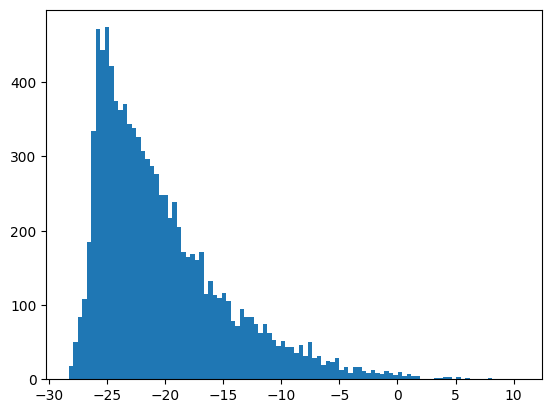

In [10]:
_ = plt.hist(median_values, bins=100)

In [ ]:
_ = plt.hist(max_values, bins=100)

In [ ]:
_ = plt.hist(min_values, bins=100)

In [ ]:
print(max_values.max(), min_values.min())

In [12]:
print(np.quantile(max_values, 0.99), np.quantile(min_values, 0.01))

60.89835460662842 -49.247029838562014


In [ ]:
print(np.median(max_values), np.median(min_values))

In [ ]:
print(np.mean(max_values), np.mean(min_values))

### Correlation


In [ ]:
def spectrogram_time_cross_corr(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    t_dim = x.shape[-1]
    x = x.unsqueeze(0)
    y = y.unsqueeze(0).flip(dims=[-1])
    corr = F.conv1d(x, y, padding=t_dim - 1) / (
        torch.linalg.norm(x) * torch.linalg.norm(y)
    )

    return corr.squeeze()

In [ ]:
gf_processor_spec = WavToSpecProcessor(
    WAVEFORMS_LOCATION,
    wav_dataframe,
    sample_rate=SAMPLE_RATE,
    add_channels=False,
    n_fft=N_FFT,
    mel_scale=True,
    spec_kwargs={
        "n_mels": N_MELS,
    },
    spec_transform=T.AmplitudeToDB(),
)
gf_dataset_spec = GF23Dataset(gf_processor_spec)

In [ ]:
idx = -1

In [ ]:
idx += 1
sample = gf_dataset_spec[idx]
left, right = sample["spectrogram"][0, ...], sample["spectrogram"][1, ...]
correlation = spectrogram_time_cross_corr(left, left)
correlation.shape

lags = torch.arange(-left.shape[-1] + 1, left.shape[-1])
corr_vec = spectrogram_time_cross_corr(left, right)

plt.figure(figsize=(10, 4))
plt.plot(lags, corr_vec)
plt.title("Channel temporal cross-correlation")
plt.xlabel("Time shift")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()

## Waveform to spectrogram


In [ ]:
converter = WavToSpecConverter(
    wav_location=WAVEFORMS_LOCATION,
    spec_location=SPECTROGRAMS_1C_LOCATION,
    dataframe=wav_dataframe,
    sample_rate=SAMPLE_RATE,
    add_channels=False,
    n_fft=N_FFT,
    mel_scale=True,
    spec_kwargs={
        "n_mels": N_MELS,
    },
    spec_transform=T.AmplitudeToDB(),
)
converter.convert_and_save()

In [ ]:
spec_dataframe = pd.read_csv(converter.metadata_path)
spec_dataset = GF23Dataset(
    SpecProcessor(location=SPECTROGRAMS_1C_LOCATION, dataframe=spec_dataframe)
)
len(spec_dataset)

In [ ]:
spec_sample = spec_dataset[0]
spec_sample

In [ ]:
spec_sample["spectrogram"].shape

### Foundation split


In [ ]:
spec_dataframe_train, spec_dataframe_val, spec_dataframe_test = train_val_test_split(
    spec_dataframe, train_size=0.9, val_size=0.05
)
print(
    f"train: {len(spec_dataframe_train)} - val: {len(spec_dataframe_val)} - test: {len(spec_dataframe_test)}"
)

spec_dataframe_train.to_csv(
    os.path.join(SPEC_1C_FOUNDATION_SPLITS_DIR, "train.csv"), index=False
)
spec_dataframe_val.to_csv(
    os.path.join(SPEC_1C_FOUNDATION_SPLITS_DIR, "val.csv"), index=False
)
spec_dataframe_test.to_csv(
    os.path.join(SPEC_1C_FOUNDATION_SPLITS_DIR, "test.csv"), index=False
)

spec_dataframe_train.to_csv(
    os.path.join(SPEC_2C_FOUNDATION_SPLITS_DIR, "train.csv"), index=False
)
spec_dataframe_val.to_csv(
    os.path.join(SPEC_2C_FOUNDATION_SPLITS_DIR, "val.csv"), index=False
)
spec_dataframe_test.to_csv(
    os.path.join(SPEC_2C_FOUNDATION_SPLITS_DIR, "test.csv"), index=False
)

# Spectrogram data


In [4]:
wav_spec_metadata = clean_dataframe(
    pd.read_csv(os.path.join(DATA_LOCATION, "spectrograms", "spec_metadata.csv"))
)
wav_spec_metadata["filename"] = wav_spec_metadata["filename"].apply(
    lambda x: f"spectrograms/one_channel/{x}"
)
wav_spec_metadata["Birdnet_detections"] = "None"
wav_spec_metadata

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2024_05_16_18_05_10,spectrograms/one_channel/GardenFiles23/er_file...,0.365511,0.23,0.951506,0.5,0.136662,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
1,test,_2024_05_16_18_05_13,spectrograms/one_channel/GardenFiles23/er_file...,0.563732,0.23,0.943251,0.5,0.129042,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
2,test,_2024_05_16_18_05_17,spectrograms/one_channel/GardenFiles23/er_file...,0.437127,0.23,0.915113,0.5,0.2405,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
3,test,_2024_05_16_18_05_20,spectrograms/one_channel/GardenFiles23/er_file...,0.386829,0.23,0.883623,0.5,0.250826,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,Bird,None
4,test,_2024_05_16_18_05_25,spectrograms/one_channel/GardenFiles23/er_file...,0.363974,0.23,0.938619,0.5,0.192257,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744283,test,_2024_06_16_12_16_34,spectrograms/one_channel/GardenFiles23/er_file...,0.18713,0.22,0.866029,0.5,0.138281,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,"Chirp, tweet",None
744284,test,_2024_06_16_12_16_43,spectrograms/one_channel/GardenFiles23/er_file...,0.52022,0.22,0.889892,0.5,0.181354,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None
744285,test,_2024_06_16_12_16_46,spectrograms/one_channel/GardenFiles23/er_file...,0.463252,0.22,0.912829,0.5,0.137533,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,"Chirp, tweet",None
744286,test,_2024_06_16_12_16_49,spectrograms/one_channel/GardenFiles23/er_file...,0.519059,0.22,0.916655,0.5,0.107621,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,"Chirp, tweet",None


In [5]:
spec_only_metadata = clean_dataframe(
    pd.read_csv(os.path.join(SPEC_DATA_LOCATION, "spec_metadata.csv"))
)
spec_only_metadata["filename"] = spec_only_metadata["filename"].apply(
    lambda x: f"specData/{x}"
)
spec_only_metadata

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2025_02_07_9_46_56,specData/GardenFiles23/er_file_2025_02_07_9_46...,0.227839,0.23,0.697303,0.5,0.167308,0.25,20250207,...,1.7,23.8,4.3,3.6,88.0,163,0,21.2,Bird,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
1,test,_2025_02_07_9_47_26,specData/GardenFiles23/er_file_2025_02_07_9_47...,0.439717,0.23,0.909036,0.5,0.031744,0.25,20250207,...,1.7,23.8,4.3,3.6,88.0,163,0,21.2,Mouse,"[{'common_name': 'Hawfinch', 'scientific_name'..."
2,test,_2025_02_07_9_47_37,specData/GardenFiles23/er_file_2025_02_07_9_47...,0.140615,0.23,0.646787,0.5,0.034754,0.25,20250207,...,1.7,14.8,3.0,3.6,88.0,138,0,25.1,Owl,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
3,test,_2025_02_07_9_47_39,specData/GardenFiles23/er_file_2025_02_07_9_47...,0.14386,0.23,0.678374,0.5,0.047686,0.25,20250207,...,1.7,14.8,3.0,3.6,88.0,138,0,25.1,Owl,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
4,test,_2025_02_07_9_48_00,specData/GardenFiles23/er_file_2025_02_07_9_48...,0.45854,0.23,0.929998,0.5,0.262344,0.25,20250207,...,1.7,14.8,3.0,3.6,88.0,138,0,25.1,Mechanisms,"[{'common_name': 'Eurasian Wren', 'scientific_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025558,test,_2025_01_24_9_35_00,specData/GardenFiles23/er_file_2025_01_24_9_35...,0.375622,0.23,0.798663,0.5,0.182899,0.24,20250124,...,6.2,16.6,4.4,8.4,86.0,221,0,22.0,Vehicle,[]
1025559,test,_2025_01_24_9_35_07,specData/GardenFiles23/er_file_2025_01_24_9_35...,0.441535,0.23,0.545172,0.5,0.205182,0.24,20250124,...,6.2,16.6,4.4,8.4,86.0,221,0,22.0,Rain,[]
1025560,test,_2025_01_24_9_35_34,specData/GardenFiles23/er_file_2025_01_24_9_35...,0.331363,0.23,0.757632,0.5,0.222029,0.24,20250124,...,6.2,16.6,4.4,8.4,86.0,221,0,22.0,Vehicle,"[{'common_name': 'Mallard', 'scientific_name':..."
1025561,test,_2025_01_24_9_35_49,specData/GardenFiles23/er_file_2025_01_24_9_35...,0.272959,0.23,0.533085,0.5,0.161724,0.24,20250124,...,6.2,16.6,4.4,8.4,86.0,221,0,22.0,Vehicle,[]


In [6]:
spec_metadata = (
    pd.concat(
        [spec_only_metadata, wav_spec_metadata],
        axis=0,
        join="inner",
        ignore_index=True,
    )
    .drop_duplicates(subset="time", keep="first")
    .sort_values(by="time", ignore_index=True)
)
spec_metadata

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2023_08_11_17_59_32,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.252234,0.5,0.500518,0.5,0.099344,0.5,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Animal,"[{'common_name': 'Tree Pipit', 'scientific_nam..."
1,test,_2023_08_11_17_59_35,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.245279,0.17,0.346069,0.5,0.037064,0.5,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Vehicle,"[{'common_name': 'Canada Goose', 'scientific_n..."
2,test,_2023_08_11_17_59_37,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.155627,0.17,0.529194,0.5,0.022406,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Silence,"[{'common_name': 'Tree Pipit', 'scientific_nam..."
3,test,_2023_08_11_17_59_40,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.139752,0.22,0.536369,0.5,0.010369,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Caw,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
4,test,_2023_08_11_17_59_43,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.269019,0.22,0.753446,0.5,0.079263,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Bird,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321373,test,_2025_03_14_9_58_42,specData/GardenFiles23/er_file_2025_03_14_9_58...,0.147571,0.22,0.96408,0.5,0.157549,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."
1321374,test,_2025_03_14_9_58_50,specData/GardenFiles23/er_file_2025_03_14_9_58...,0.20654,0.22,0.945449,0.5,0.057663,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,"Chirp, tweet","[{'common_name': 'Great Tit', 'scientific_name..."
1321375,test,_2025_03_14_9_59_12,specData/GardenFiles23/er_file_2025_03_14_9_59...,0.141525,0.22,0.571693,0.5,0.040414,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,[]
1321376,test,_2025_03_14_9_59_32,specData/GardenFiles23/er_file_2025_03_14_9_59...,0.140859,0.22,0.882149,0.5,0.117885,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."


In [7]:
spec_metadata["time"].min(), spec_metadata["time"].max()

('_2023_08_11_17_59_32', '_2025_03_14_9_59_59')

In [8]:
spec_metadata["MIT_AST_label"].unique()

<StringArray>
[             'Animal',             'Vehicle',             'Silence',
                 'Caw',                'Bird',              'Squawk',
                'Door',                 'Owl',                'Tick',
        'Sliding door',
 ...
              'Maraca',           'Breathing',           'Dial tone',
                'Gush',    'Brass instrument',  'Musical instrument',
 'Propeller, airscrew',               'Goose',              'Squish',
        'Male singing']
Length: 315, dtype: string

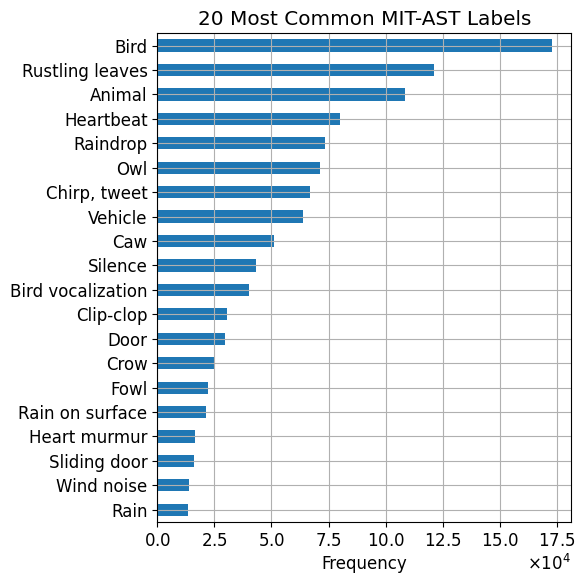

In [9]:
label_counts = (
    spec_metadata["MIT_AST_label"].value_counts().sort_values(ascending=False).head(20)
)

plt.figure(figsize=(6, 6))
label_counts.rename(
    {
        "Bird vocalization, bird call, bird song": "Bird vocalization",
        "Heart sounds, heartbeat": "Heartbeat",
        "Wind noise (microphone)": "Wind noise",
    }
).plot(kind="barh")
plt.xlabel("Frequency")
plt.gca().set_ylabel("")
plt.gca().xaxis.set_major_formatter(formatter)
plt.title("20 Most Common MIT-AST Labels")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
labels = []
confidences = []

for row in spec_metadata.itertuples():
    detections = ast.literal_eval(str(row.Birdnet_detections))
    if detections is not None:
        for x in detections:
            labels.append(x["common_name"])
            confidences.append(x["confidence"])

len(Counter(labels))

190

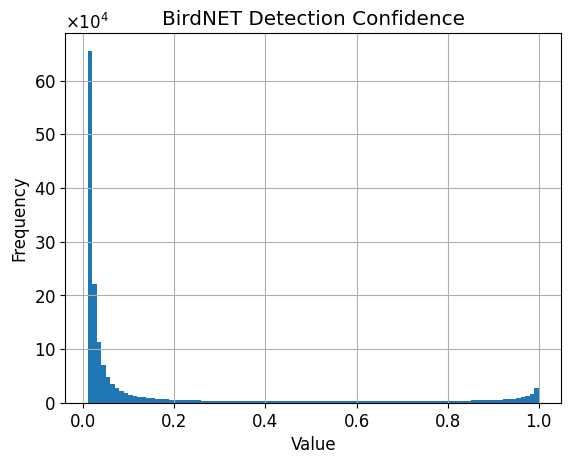

In [11]:
plt.hist(confidences, bins=100)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("BirdNET Detection Confidence")
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid()
plt.show()

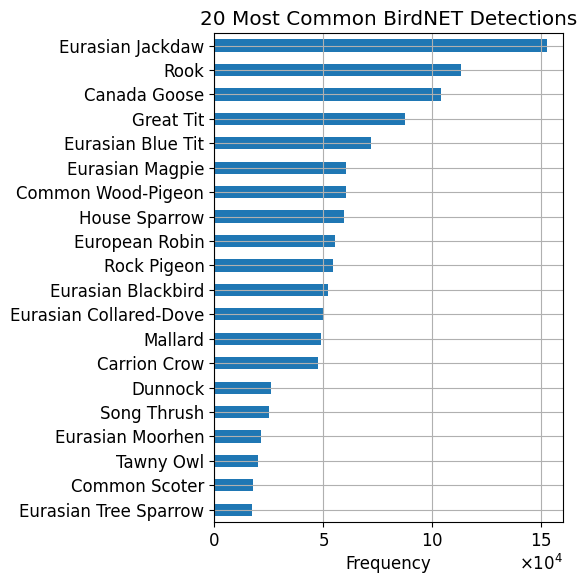

In [12]:
bird_label_counts = pd.Series(dict(Counter(labels).most_common(20)))

# Plot
plt.figure(figsize=(6, 6))
bird_label_counts.plot(kind="barh")
plt.xlabel("Frequency")
plt.gca().set_ylabel("")
plt.gca().xaxis.set_major_formatter(formatter)
plt.title("20 Most Common BirdNET Detections")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

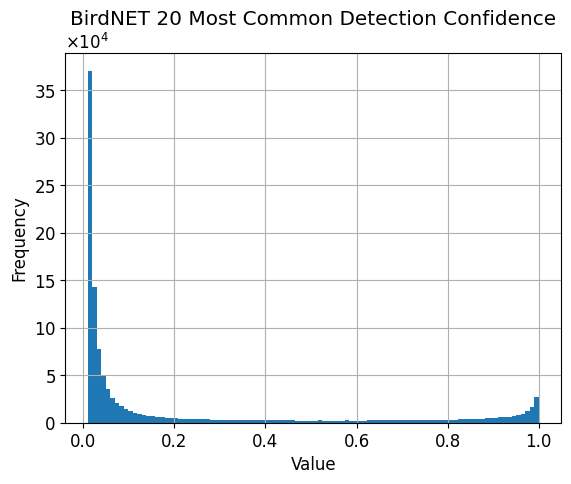

In [13]:
most_common = bird_label_counts.index.tolist()
most_common_confidences = []

for row in spec_metadata.itertuples():
    detections = ast.literal_eval(str(row.Birdnet_detections))
    if detections is not None:
        for x in detections:
            if x["common_name"] in most_common:
                most_common_confidences.append(x["confidence"])

plt.hist(most_common_confidences, bins=100)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("BirdNET 20 Most Common Detection Confidence")
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid()
plt.show()

In [14]:
spec_metadata.dtypes

sessionId             string[python]
time                  string[python]
filename                      object
th1                          Float64
th1_value                    Float64
th2                          Float64
th2_value                    Float64
th3                          Float64
th3_value                    Float64
wudate                         Int64
datetime              string[python]
precipRate                   Float64
pressureMax                  Float64
dewptAvg                     Float64
windgustHigh                 Float64
windspeedAvg                 Float64
tempAve                      Float64
humidityAvg                  Float64
winddirAvg                     Int64
uvHigh                         Int64
solarRadiationHigh           Float64
MIT_AST_label         string[python]
Birdnet_detections            object
dtype: object

## Spectrogram analysis


In [ ]:
spec_processor = SpecProcessor(
    location=SPEC_DATA_LOCATION,
    dataframe=spec_metadata,
    # spec_transform=T.AmplitudeToDB()
)

num_samples = 10_000
rand_idx = np.random.default_rng(seed=1234).choice(
    len(spec_processor.dataframe), size=num_samples
)

max_values = np.empty(shape=(num_samples,))
min_values = np.empty(shape=(num_samples,))
mean_values = np.empty(shape=(num_samples,))
std_values = np.empty(shape=(num_samples,))
median_values = np.empty(shape=(num_samples,))

for i, idx in enumerate(tqdm(rand_idx)):
    rand_sample = spec_processor.process(idx)
    mel_spectrogram = rand_sample["spectrogram"]
    max_values[i] = torch.max(mel_spectrogram)
    min_values[i] = torch.min(mel_spectrogram)
    mean_values[i] = torch.mean(mel_spectrogram)
    std_values[i] = torch.std(mel_spectrogram)
    median_values[i] = torch.median(mel_spectrogram)

In [ ]:
_ = plt.hist(mean_values, bins=100)

In [ ]:
_ = plt.hist(median_values, bins=100)

In [ ]:
_ = plt.hist(max_values, bins=100)

In [ ]:
_ = plt.hist(min_values, bins=100)

In [ ]:
print(max_values.max(), min_values.min())

In [ ]:
idx = -1

In [ ]:
idx += 1
sample_idx = rand_idx[idx]
sample = spec_processor.process(sample_idx)
plot_spectrogram(sample["spectrogram"], sample["sample_id"], to_db=False)

## Targets


In [15]:
spec_metadata_targets = spec_metadata.copy()

### Bird label


In [16]:
spec_metadata_targets["MIT_AST_Bird_detection"] = spec_metadata_targets[
    "MIT_AST_label"
].apply(
    lambda x: 1 - map_label(x, index=True)  # type: ignore
)

In [17]:
spec_metadata_targets["MIT_AST_Bird_detection"].value_counts()

MIT_AST_Bird_detection
0    860763
1    460615
Name: count, dtype: int64

In [18]:
def get_most_confident_bird_detection(detections: str) -> pd.Series:
    detections_: Optional[list[dict]] = ast.literal_eval(detections)
    if detections_ is None:
        return pd.Series(
            {
                "Birdnet_most_confident": "N/A",
                "Birdnet_max_confidence": -1.0,
            }
        )

    most_confident = (
        np.argmax([detection["confidence"] for detection in detections_])
        if len(detections_) > 0
        else None
    )

    return pd.Series(
        {
            "Birdnet_most_confident": (
                detections_[most_confident]["common_name"]
                if most_confident is not None
                else "None"
            ),
            "Birdnet_max_confidence": (
                detections_[most_confident]["confidence"]
                if most_confident is not None
                else 0.0
            ),
        }
    )


spec_metadata_targets[["Birdnet_most_confident", "Birdnet_max_confidence"]] = (
    spec_metadata_targets["Birdnet_detections"].apply(get_most_confident_bird_detection)
)

In [19]:
spec_metadata_targets["Birdnet_most_confident"].value_counts().sort_values(
    ascending=False
).head(20)

Birdnet_most_confident
None                      365618
N/A                       295815
Eurasian Jackdaw          123121
Canada Goose               82494
Great Tit                  45509
House Sparrow              44911
Eurasian Blue Tit          34802
Rock Pigeon                34636
Eurasian Blackbird         27502
Common Wood-Pigeon         27344
European Robin             21252
Eurasian Collared-Dove     20322
Mallard                    17291
Rook                       16043
Eurasian Magpie            13351
Tawny Owl                  13211
Carrion Crow                8987
Common Scoter               8645
Dunnock                     7210
Eurasian Moorhen            7186
Name: count, dtype: int64

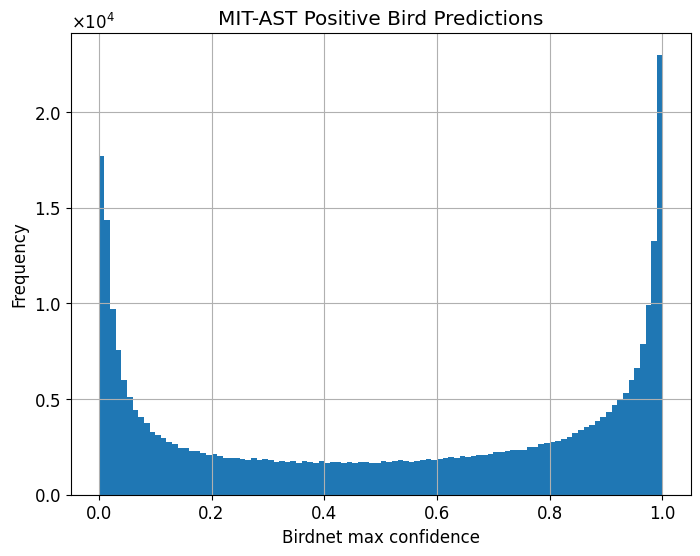

In [20]:
mit_ast_bird = spec_metadata_targets[
    spec_metadata_targets["MIT_AST_Bird_detection"] == 1
]
plt.figure(figsize=(8, 6))
_ = mit_ast_bird["Birdnet_max_confidence"][
    mit_ast_bird["Birdnet_max_confidence"] > -1.0
].hist(bins=100)
_ = plt.title("MIT-AST Positive Bird Predictions")
_ = plt.xlabel("Birdnet max confidence")
_ = plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(formatter)

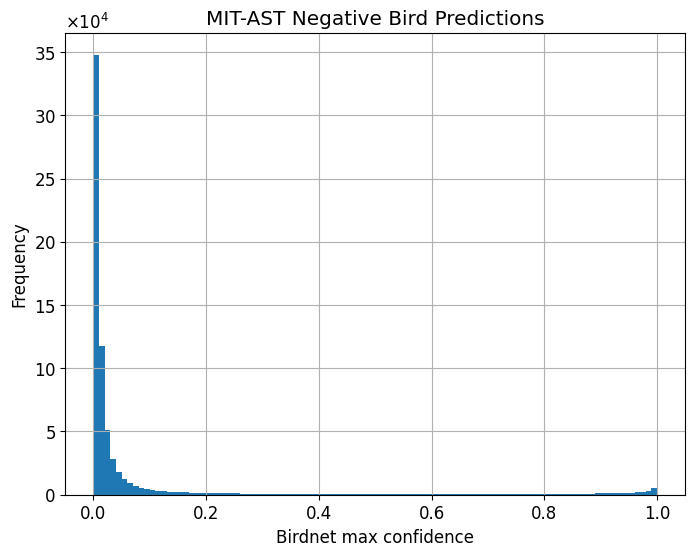

In [21]:
mit_ast_not_bird = spec_metadata_targets[
    spec_metadata_targets["MIT_AST_Bird_detection"] == 0
]
_ = mit_ast_not_bird["Birdnet_max_confidence"][
    mit_ast_not_bird["Birdnet_max_confidence"] > -1.0
].hist(bins=100, figsize=(8, 6))
_ = plt.title("MIT-AST Negative Bird Predictions")
_ = plt.xlabel("Birdnet max confidence")
_ = plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(formatter)

In [22]:
def create_bird_label(row: pd.Series) -> int:
    if row["Birdnet_detections"] == "None":
        return row["MIT_AST_Bird_detection"]
    if (row["MIT_AST_Bird_detection"] == 0) and (row["Birdnet_max_confidence"] < 0.5):
        return 0
    if (row["MIT_AST_Bird_detection"] == 0) and (row["Birdnet_max_confidence"] >= 0.5):
        return 1
    if (row["MIT_AST_Bird_detection"] == 1) and (row["Birdnet_max_confidence"] >= 0.2):
        return 1
    return 0


spec_metadata_targets["Bird_label"] = spec_metadata_targets.apply(
    create_bird_label, axis=1
)
spec_metadata_targets["Bird_label"].value_counts()

Bird_label
0    918048
1    403330
Name: count, dtype: int64

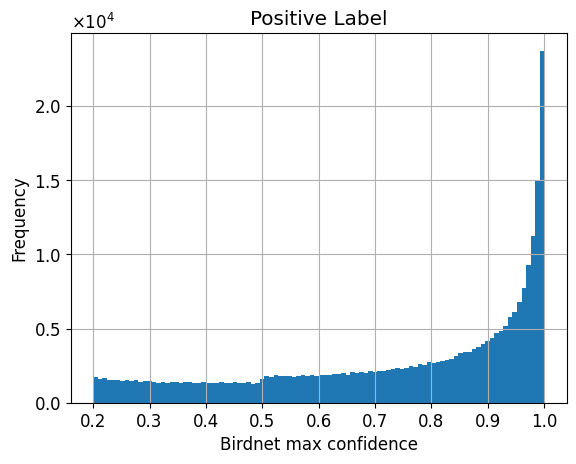

In [23]:
_ = spec_metadata_targets[
    (spec_metadata_targets["Bird_label"] == 1)
    & (spec_metadata_targets["Birdnet_detections"] != "None")
]["Birdnet_max_confidence"].hist(bins=100)
_ = plt.title("Positive Label")
_ = plt.xlabel("Birdnet max confidence")
_ = plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(formatter)

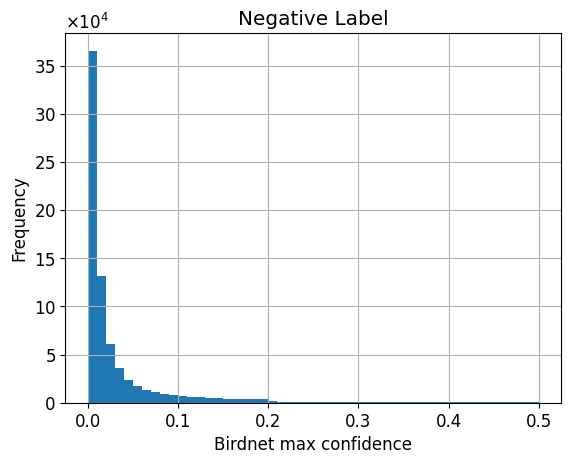

In [24]:
_ = spec_metadata_targets[
    (spec_metadata_targets["Bird_label"] == 0)
    & (spec_metadata_targets["Birdnet_detections"] != "None")
]["Birdnet_max_confidence"].hist(bins=50)
_ = plt.title("Negative Label")
_ = plt.xlabel("Birdnet max confidence")
_ = plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(formatter)

### Weather metadata


In [25]:
spec_metadata_targets["winddirAvg_sin"] = [
    math.sin(math.radians(x)) for x in spec_metadata_targets["winddirAvg"]
]
spec_metadata_targets["winddirAvg_cos"] = [
    math.cos(math.radians(x)) for x in spec_metadata_targets["winddirAvg"]
]

In [26]:
weather_metadata = [
    "precipRate",
    "pressureMax",
    "dewptAvg",
    "windgustHigh",
    "windspeedAvg",
    "tempAve",
    "humidityAvg",
    "uvHigh",
    "solarRadiationHigh",
]
weather_labels = [f"{x}_label" for x in weather_metadata] + [
    "winddirAvg_sin",
    "winddirAvg_cos",
]

In [27]:
spec_metadata_targets[weather_metadata].describe(
    percentiles=[x / 5 for x in range(1, 5)]
)

,precipRate,pressureMax,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,uvHigh,solarRadiationHigh
count,1321378.0,1321378.0,1321378.0,1321378.0,1321378.0,1321378.0,1321378.0,1321378.0,1321378.0
mean,0.301758,1013.845139,8.480999,10.019893,3.211502,10.982032,86.116409,0.749829,102.490308
std,1.413818,14.522289,5.279682,6.949124,2.58513,6.396297,13.404845,1.616741,177.728421
min,0.0,977.92,-9.9,0.0,0.0,-6.5,34.1,0.0,0.0
20%,0.0,1002.03,4.3,3.5,0.7,5.7,75.9,0.0,0.0
40%,0.0,1008.53,7.2,7.2,2.1,9.1,86.6,0.0,2.9
50%,0.0,1011.72,8.3,9.3,2.8,10.4,90.0,0.0,22.5
60%,0.0,1015.04,9.5,11.1,3.5,11.5,93.2,0.0,46.7
80%,0.0,1027.43,13.4,14.8,5.3,16.3,98.0,1.0,160.5
max,60.6,1053.84,22.8,43.9,17.3,32.8,99.0,14.0,1909.5


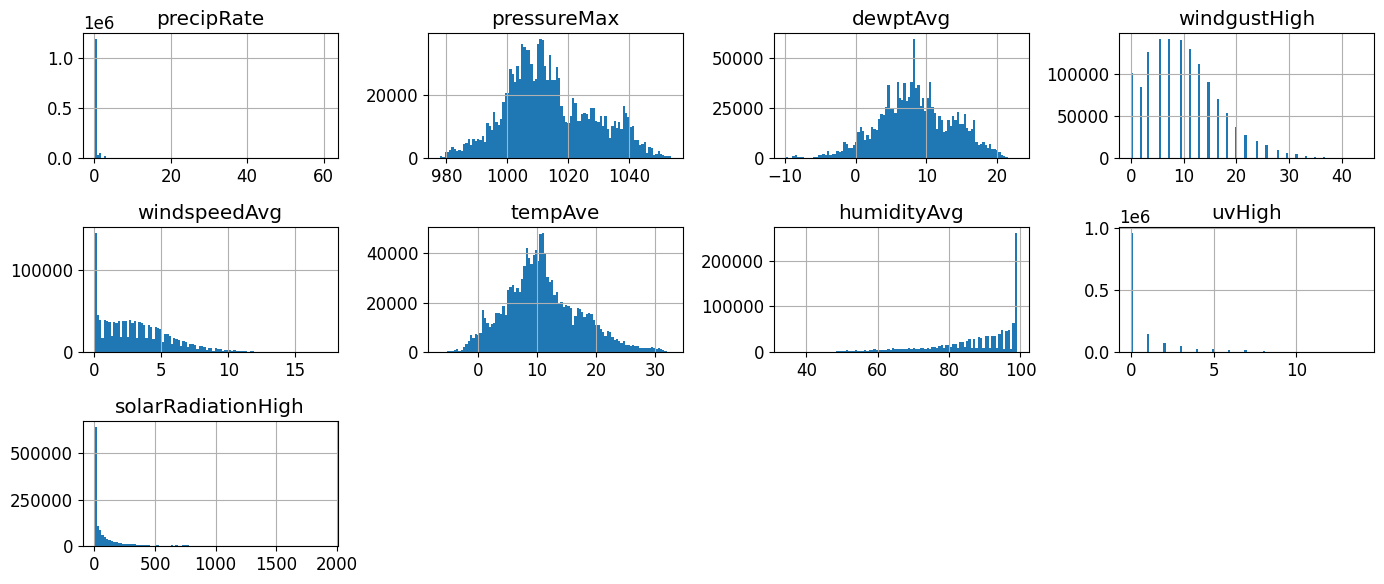

In [28]:
_ = spec_metadata_targets[weather_metadata].hist(
    bins=100, figsize=(14, 6), layout=(3, 4)
)
plt.tight_layout()

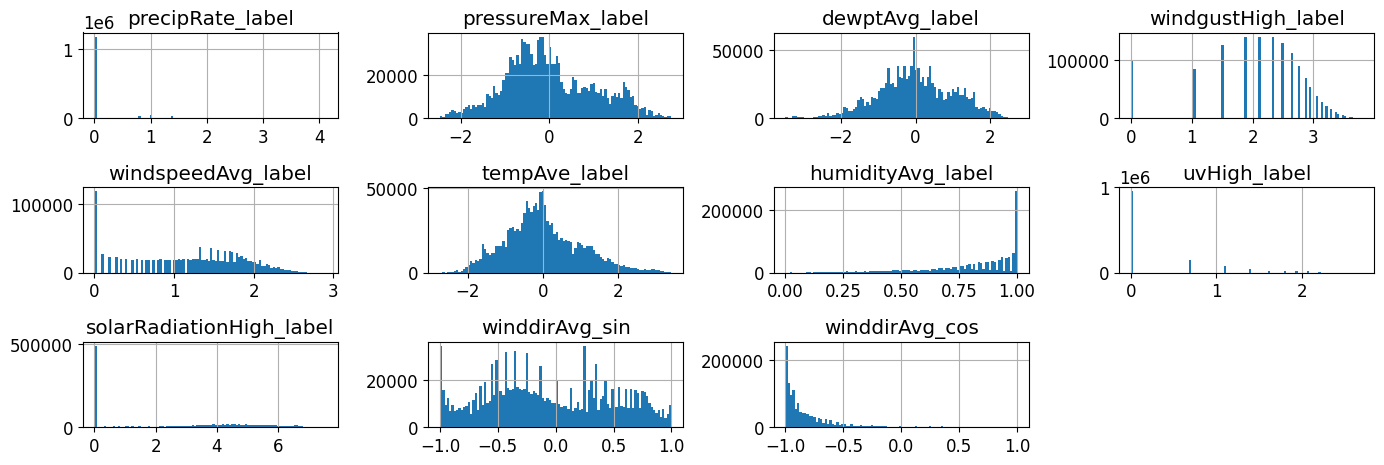

In [29]:
transforms = {
    "precipRate": FunctionTransformer(func=np.log1p),
    "pressureMax": StandardScaler(),
    "dewptAvg": StandardScaler(),
    "windgustHigh": FunctionTransformer(func=np.log1p),
    "windspeedAvg": FunctionTransformer(func=np.log1p),
    "tempAve": StandardScaler(),
    "humidityAvg": MinMaxScaler(),
    "uvHigh": FunctionTransformer(func=np.log1p),
    "solarRadiationHigh": FunctionTransformer(func=np.log1p),
}

for label, transform in transforms.items():
    spec_metadata_targets[f"{label}_label"] = transform.fit_transform(
        spec_metadata_targets[[label]]
    )
_ = spec_metadata_targets[weather_labels].hist(bins=100, figsize=(14, 5), layout=(3, 4))
plt.tight_layout()

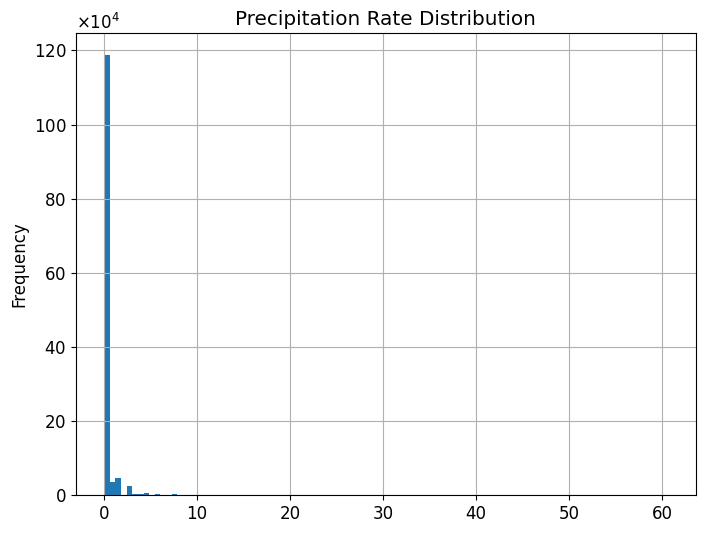

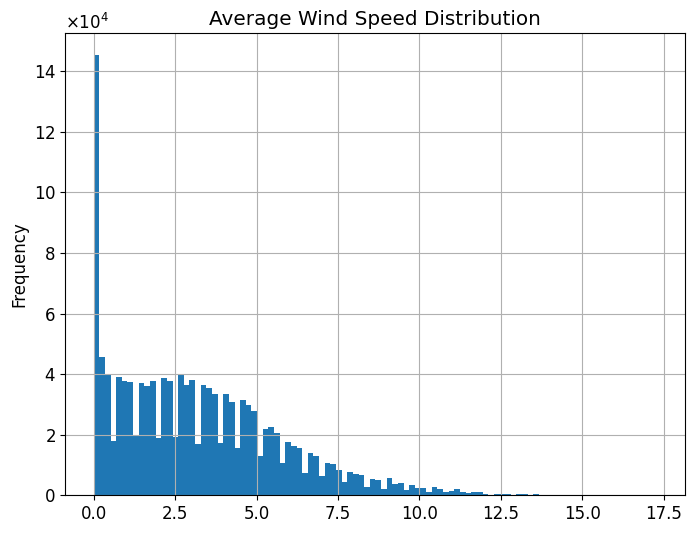

In [30]:
selected_columns_map = {
    "precipRate": "Precipitation Rate",
    "windspeedAvg": "Average Wind Speed",
}
for label, label_name in selected_columns_map.items():
    plt.figure(figsize=(8, 6))
    spec_metadata_targets[label].hist(bins=100)
    plt.title(f"{label_name} Distribution")
    plt.ylabel("Frequency")
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

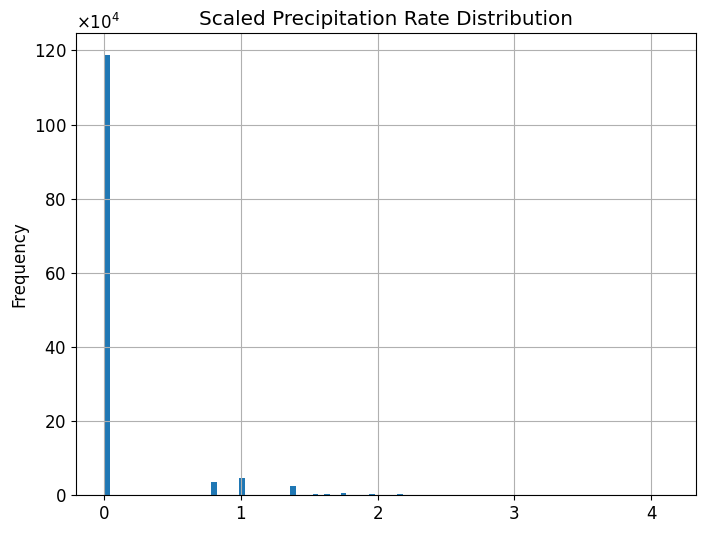

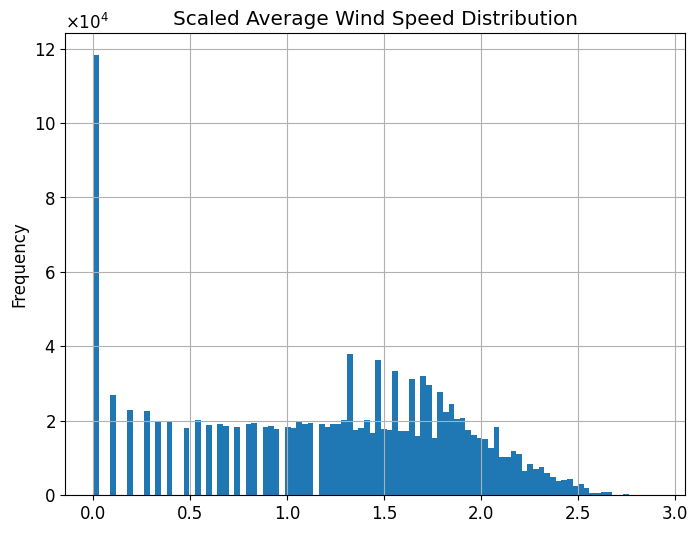

In [31]:
selected_labels_map = {
    "precipRate_label": "Scaled Precipitation Rate",
    "windspeedAvg_label": "Scaled Average Wind Speed",
}
for label, label_name in selected_labels_map.items():
    plt.figure(figsize=(8, 6))
    spec_metadata_targets[label].hist(bins=100)
    plt.title(f"{label_name} Distribution")
    plt.ylabel("Frequency")
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

### Temporal metadata


In [32]:
temporal_angles = [
    "Time_of_Day_angle",
    "Day_of_Year_angle",
]
temporal_labels = [
    "Time_of_Day_sin",
    "Time_of_Day_cos",
    "Day_of_Year_sin",
    "Day_of_Year_cos",
]

In [33]:
def create_temporal_labels(row: pd.Series) -> pd.Series:
    dt = datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")

    time_of_day = dt.hour * 3600 + dt.minute * 60 + dt.second
    time_of_day_angle = 2 * math.pi * time_of_day / 86400

    day_of_year = dt.timetuple().tm_yday
    day_of_year_angle = 2 * math.pi * day_of_year / 365

    return pd.Series(
        {
            "Time_of_Day_angle": time_of_day_angle,
            "Day_of_Year_angle": day_of_year_angle,
            "Time_of_Day_sin": math.sin(time_of_day_angle),
            "Time_of_Day_cos": math.cos(time_of_day_angle),
            "Day_of_Year_sin": math.sin(day_of_year_angle),
            "Day_of_Year_cos": math.cos(day_of_year_angle),
        }
    )


spec_metadata_targets[temporal_angles + temporal_labels] = spec_metadata_targets.apply(
    create_temporal_labels, axis=1
)

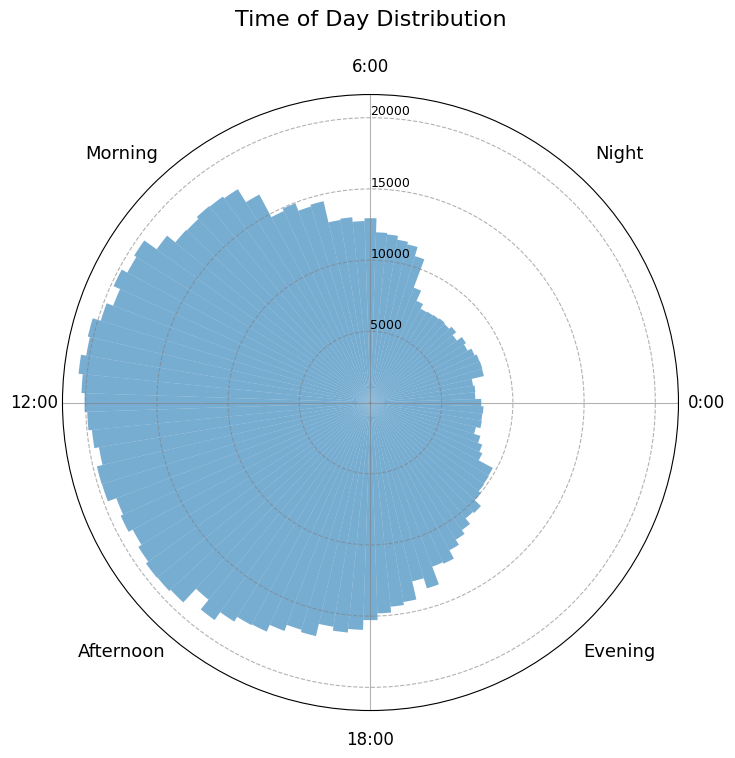

In [34]:
bins = 24 * 4
time_counts, edges = np.histogram(
    spec_metadata_targets["Time_of_Day_angle"], bins=bins, range=(0, 2 * np.pi)
)
widths = np.diff(edges)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})

ax.bar(
    edges[:-1],
    time_counts,
    width=widths,
    edgecolor="none",
    facecolor="C0",
    alpha=0.6,
)

hour_ticks = np.array([0, 6, 12, 18]) / 24 * 2 * np.pi
hour_labels = ["0:00", "6:00", "12:00", "18:00"]
ax.set_xticks(hour_ticks)
ax.set_xticklabels(hour_labels, fontsize=12)
ax.tick_params(axis="x", which="major", pad=10)

part_mid = np.array([3, 9, 15, 21]) / 24 * 2 * np.pi
part_labels = ["Night", "Morning", "Afternoon", "Evening"]
r_out = time_counts.max() * 1.2
for angle, lab in zip(part_mid, part_labels):
    ax.text(angle, r_out, lab, ha="center", va="center", fontsize=13)

r_levels = [5_000 * s for s in range(1, 5)]
ax.set_rgrids(  # type: ignore
    r_levels, labels=[f"{int(r):d}" for r in r_levels], angle=90, fontsize=9
)
for line in ax.yaxis.get_gridlines():
    line.set_linestyle("--")
ax.grid(True, color="gray", alpha=0.6)

ax.set_title(f"Time of Day Distribution", va="bottom", fontsize=16, pad=20)
plt.show()

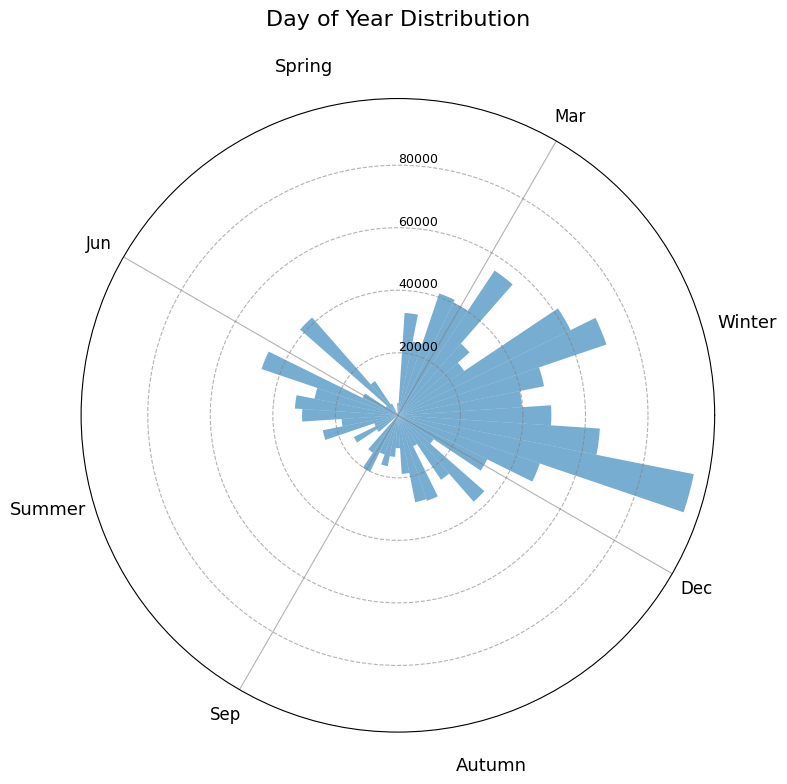

In [35]:
bins = 12 * 4
day_counts, edges = np.histogram(
    spec_metadata_targets["Day_of_Year_angle"], bins=bins, range=(0, 2 * np.pi)
)
widths = np.diff(edges)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})

ax.bar(
    edges[:-1],
    day_counts,
    width=widths,
    edgecolor="none",
    facecolor="C0",
    alpha=0.6,
)

quarters = {"Dec": 11, "Mar": 2, "Jun": 5, "Sep": 8}
tick_locs = np.array(list(quarters.values())) / 12 * 2 * np.pi
tick_names = list(quarters.keys())
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_names, fontsize=12)
ax.tick_params(axis="x", pad=10)

start = np.array(list(quarters.values())) / 12 * 2 * np.pi
end = np.roll(start, -1)
end = np.where(end <= start, end + 2 * np.pi, end)
mids = (start + end) / 2 % (2 * np.pi)
season_labels = ["Winter", "Spring", "Summer", "Autumn"]

r_out = day_counts.max() * 1.2
for angle, label in zip(mids, season_labels):
    ax.text(angle, r_out, label, ha="center", va="center", fontsize=13)

r_levels = [20_000 * s for s in range(1, 5)]
ax.set_rgrids(  # type: ignore
    r_levels, labels=[f"{int(r):d}" for r in r_levels], angle=90, fontsize=9
)
for line in ax.yaxis.get_gridlines():
    line.set_linestyle("--")
ax.grid(True, color="gray", alpha=0.6)

ax.set_title(f"Day of Year Distribution", va="bottom", fontsize=16, pad=50)
plt.tight_layout()
plt.show()

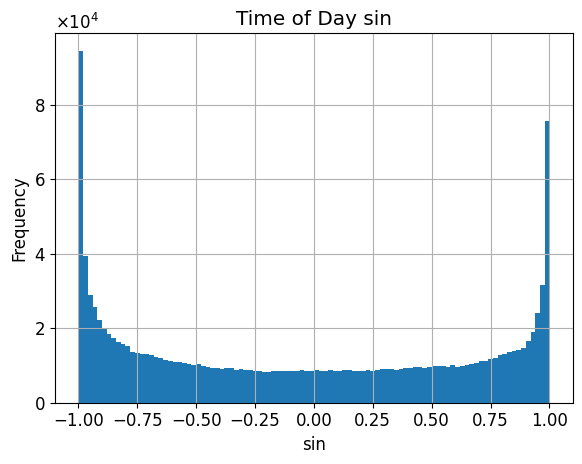

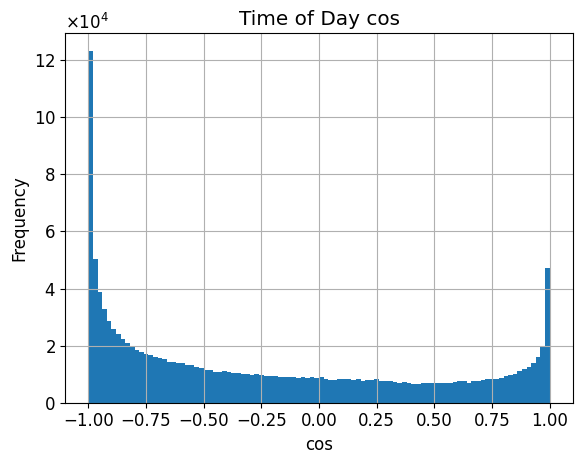

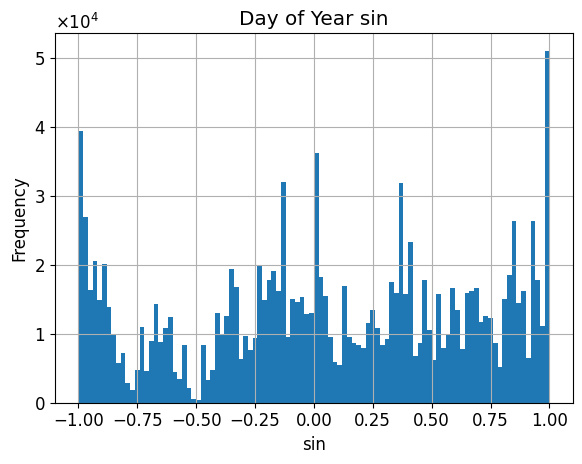

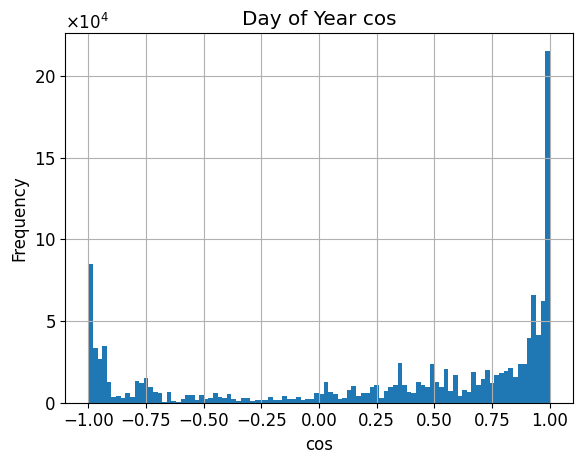

In [36]:
for label in temporal_labels:
    plt.figure()
    _ = spec_metadata_targets[label].hist(bins=100)
    _ = plt.title(label.replace("_", " "))
    _ = plt.xlabel(label.split("_")[-1])
    _ = plt.ylabel("Frequency")
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(formatter)

In [37]:
spec_metadata_targets = spec_metadata_targets.convert_dtypes()
spec_metadata_targets.dtypes

sessionId                   string[python]
time                        string[python]
filename                    string[python]
th1                                Float64
th1_value                          Float64
th2                                Float64
th2_value                          Float64
th3                                Float64
th3_value                          Float64
wudate                               Int64
datetime                    string[python]
precipRate                         Float64
pressureMax                        Float64
dewptAvg                           Float64
windgustHigh                       Float64
windspeedAvg                       Float64
tempAve                            Float64
humidityAvg                        Float64
winddirAvg                           Int64
uvHigh                               Int64
solarRadiationHigh                 Float64
MIT_AST_label               string[python]
Birdnet_detections          string[python]
MIT_AST_Bir

# Splits


## Test set


In [38]:
test_set = spec_metadata_targets[
    spec_metadata_targets["time"].isin(wav_spec_metadata["time"])
].sample(n=100_000, random_state=42, ignore_index=True)
test_set["filename"] = test_set["filename"].apply(
    lambda x: x.replace("specData", f"spectrograms/one_channel/")
)
assert test_set["time"].nunique() == len(test_set)
test_set

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,tempAve_label,humidityAvg_label,uvHigh_label,solarRadiationHigh_label,Time_of_Day_angle,Day_of_Year_angle,Time_of_Day_sin,Time_of_Day_cos,Day_of_Year_sin,Day_of_Year_cos
0,test,_2024_05_18_5_09_17,spectrograms/one_channel/GardenFiles23/er_file...,0.177093,0.24,0.801408,0.5,0.117688,0.23,20240518,...,0.424929,1.0,0.0,0.0,1.349503,2.392775,0.975614,0.219491,0.680773,-0.732494
1,test,_2024_03_28_22_24_52,spectrograms/one_channel/GardenFiles23/er_file...,0.143735,0.25,0.883673,0.67,0.16979,0.27,20240328,...,-0.090995,0.522342,0.0,0.0,5.868088,1.51485,-0.403279,0.915077,0.998435,0.055917
2,test,_2024_06_15_19_57_53,spectrograms/one_channel//GardenFiles23/er_fil...,0.315291,0.22,0.625621,0.5,0.096684,0.23,20240615,...,0.97212,0.48074,0.0,3.858622,5.226752,2.874772,-0.870606,0.49198,0.263665,-0.964614
3,test,_2024_07_05_11_39_07,spectrograms/one_channel//GardenFiles23/er_fil...,0.178793,0.2,0.88798,0.5,0.697204,0.22,20240705,...,1.112827,0.583975,1.098612,5.483967,3.050472,3.219057,0.090995,-0.995851,-0.077386,-0.997001
4,test,_2024_01_22_0_35_34,spectrograms/one_channel/GardenFiles23/er_file...,0.318508,0.19,0.886567,0.5,0.368689,0.19,20240122,...,-0.388042,0.865948,0.0,0.0,0.155189,0.378713,0.154567,0.987982,0.369725,0.929141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,test,_2024_03_20_14_39_19,spectrograms/one_channel/GardenFiles23/er_file...,0.331622,0.24,0.378794,0.67,0.104253,0.24,20240320,...,1.347338,0.359014,1.609438,6.084727,3.836743,1.377137,-0.640501,-0.767958,0.981306,0.192452
99996,test,_2023_10_24_13_05_18,spectrograms/one_channel/GardenFiles23/er_file...,0.228246,0.22,0.273017,0.5,0.007747,0.23,20231024,...,0.284222,0.90755,0.0,3.370738,3.426518,5.112619,-0.281085,-0.959683,-0.920971,0.38963
99997,test,_2024_03_24_9_59_08,spectrograms/one_channel/GardenFiles23/er_file...,0.29901,0.25,0.768733,0.67,0.366776,0.27,20240324,...,-0.388042,0.70416,1.386294,5.843544,2.614212,1.445993,0.503271,-0.864128,0.992222,0.124479
99998,test,_2023_12_11_4_10_42,spectrograms/one_channel/GardenFiles23/er_file...,0.433933,0.23,0.7306,0.5,0.578636,0.24,20231211,...,-0.090995,0.876733,0.0,0.0,1.093885,5.938901,0.888417,0.459037,-0.337523,0.941317


## Foundation


In [39]:
foundation_train_val = spec_metadata[~spec_metadata["time"].isin(test_set["time"])]
assert foundation_train_val["time"].nunique() == len(foundation_train_val)
foundation_train_val

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2023_08_11_17_59_32,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.252234,0.5,0.500518,0.5,0.099344,0.5,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Animal,"[{'common_name': 'Tree Pipit', 'scientific_nam..."
1,test,_2023_08_11_17_59_35,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.245279,0.17,0.346069,0.5,0.037064,0.5,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Vehicle,"[{'common_name': 'Canada Goose', 'scientific_n..."
2,test,_2023_08_11_17_59_37,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.155627,0.17,0.529194,0.5,0.022406,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Silence,"[{'common_name': 'Tree Pipit', 'scientific_nam..."
3,test,_2023_08_11_17_59_40,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.139752,0.22,0.536369,0.5,0.010369,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Caw,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
4,test,_2023_08_11_17_59_43,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.269019,0.22,0.753446,0.5,0.079263,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Bird,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321373,test,_2025_03_14_9_58_42,specData/GardenFiles23/er_file_2025_03_14_9_58...,0.147571,0.22,0.96408,0.5,0.157549,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."
1321374,test,_2025_03_14_9_58_50,specData/GardenFiles23/er_file_2025_03_14_9_58...,0.20654,0.22,0.945449,0.5,0.057663,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,"Chirp, tweet","[{'common_name': 'Great Tit', 'scientific_name..."
1321375,test,_2025_03_14_9_59_12,specData/GardenFiles23/er_file_2025_03_14_9_59...,0.141525,0.22,0.571693,0.5,0.040414,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,[]
1321376,test,_2025_03_14_9_59_32,specData/GardenFiles23/er_file_2025_03_14_9_59...,0.140859,0.22,0.882149,0.5,0.117885,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."


In [40]:
foundation_val = foundation_train_val.sample(
    n=100_000, random_state=42, replace=False
).reset_index(drop=True)
assert foundation_val["time"].nunique() == len(foundation_val)
foundation_val

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2023_12_26_15_07_55,specData/GardenFiles23/er_file_2023_12_26_15_0...,0.245801,0.28,0.608101,0.5,0.018489,0.32,20231226,...,6.9,13.0,4.2,9.8,82.0,225,0,18.1,Squeak,"[{'common_name': 'Eurasian Jackdaw', 'scientif..."
1,test,_2024_12_13_11_42_05,specData/GardenFiles23/er_file_2024_12_13_11_4...,0.538683,0.19,0.572213,0.5,0.09074,0.23,20241213,...,0.3,3.5,0.3,1.4,93.0,136,0,20.8,Owl,"[{'common_name': 'Eurasian Blue Tit', 'scienti..."
2,test,_2025_01_11_17_11_40,specData/GardenFiles23/er_file_2025_01_11_17_1...,0.229572,0.21,0.954367,0.5,0.983873,0.23,20250111,...,-0.2,5.5,1.7,0.0,99.0,158,0,0.0,"Heart sounds, heartbeat",[]
3,test,_2023_10_25_13_35_17,spectrograms/one_channel/GardenFiles23/er_file...,0.158988,0.22,0.572652,0.5,0.034416,0.23,20231025,...,9.9,7.2,2.1,10.1,99.0,142,0,51.1,Rain on surface,None
4,test,_2024_01_15_1_28_10,specData/GardenFiles23/er_file_2024_01_15_1_28...,0.403705,0.23,0.539433,0.5,0.0085,0.24,20240115,...,0.8,7.2,3.1,1.1,99.0,169,0,0.0,Clip-clop,"[{'common_name': 'Canada Goose', 'scientific_n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,test,_2025_03_11_17_37_15,specData/GardenFiles23/er_file_2025_03_11_17_3...,0.140331,0.22,0.545977,0.5,0.074828,0.24,20250311,...,1.6,11.1,4.3,7.8,65.2,255,0,38.5,Animal,"[{'common_name': 'Barnacle Goose', 'scientific..."
99996,test,_2025_02_13_15_22_57,specData/GardenFiles23/er_file_2025_02_13_15_2...,0.146801,0.2,0.578331,0.5,0.004625,0.2,20250213,...,-1.5,5.5,1.0,-0.6,94.0,156,0,22.0,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."
99997,test,_2024_02_12_10_29_35,specData/GardenFiles23/er_file_2024_02_12_10_2...,0.558663,0.21,0.919299,0.81,0.148142,0.24,20240212,...,6.8,9.3,3.7,8.1,91.0,202,1,116.6,Owl,"[{'common_name': 'Eurasian Collared-Dove', 'sc..."
99998,test,_2023_12_21_10_21_23,specData/GardenFiles23/er_file_2023_12_21_10_2...,0.305006,0.23,0.500113,0.46,0.039108,0.25,20231221,...,9.8,27.7,7.4,10.0,99.0,180,0,9.1,Crow,"[{'common_name': 'Eurasian Jackdaw', 'scientif..."


In [41]:
foundation_train = foundation_train_val[
    ~foundation_train_val["time"].isin(foundation_val["time"])
].reset_index(drop=True)
assert foundation_train["time"].nunique() == len(foundation_train)
foundation_train

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2023_08_11_17_59_32,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.252234,0.5,0.500518,0.5,0.099344,0.5,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Animal,"[{'common_name': 'Tree Pipit', 'scientific_nam..."
1,test,_2023_08_11_17_59_35,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.245279,0.17,0.346069,0.5,0.037064,0.5,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Vehicle,"[{'common_name': 'Canada Goose', 'scientific_n..."
2,test,_2023_08_11_17_59_37,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.155627,0.17,0.529194,0.5,0.022406,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Silence,"[{'common_name': 'Tree Pipit', 'scientific_nam..."
3,test,_2023_08_11_17_59_40,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.139752,0.22,0.536369,0.5,0.010369,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Caw,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
4,test,_2023_08_11_17_59_43,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.269019,0.22,0.753446,0.5,0.079263,0.21,20230811,...,20.1,3.5,0.8,28.0,62.4,188,4,468.9,Bird,"[{'common_name': 'Common Wood-Pigeon', 'scient..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121373,test,_2025_03_14_9_58_42,specData/GardenFiles23/er_file_2025_03_14_9_58...,0.147571,0.22,0.96408,0.5,0.157549,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."
1121374,test,_2025_03_14_9_58_50,specData/GardenFiles23/er_file_2025_03_14_9_58...,0.20654,0.22,0.945449,0.5,0.057663,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,"Chirp, tweet","[{'common_name': 'Great Tit', 'scientific_name..."
1121375,test,_2025_03_14_9_59_12,specData/GardenFiles23/er_file_2025_03_14_9_59...,0.141525,0.22,0.571693,0.5,0.040414,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,[]
1121376,test,_2025_03_14_9_59_32,specData/GardenFiles23/er_file_2025_03_14_9_59...,0.140859,0.22,0.882149,0.5,0.117885,0.24,20250314,...,2.5,7.2,1.3,6.3,76.3,233,3,327.9,Bird,"[{'common_name': 'Great Tit', 'scientific_name..."


In [42]:
foundation_train.to_csv(os.path.join(FOUNDATION_SPLITS_DIR, "train.csv"), index=False)
foundation_val.to_csv(os.path.join(FOUNDATION_SPLITS_DIR, "val.csv"), index=False)
test_set.to_csv(os.path.join(FOUNDATION_SPLITS_DIR, "test.csv"), index=False)

## Contrastive


In [43]:
contrastive_metadata = wav_spec_metadata.copy()
contrastive_metadata["filename"] = contrastive_metadata["filename"].apply(
    lambda x: x.replace("one_channel", "two_channels")
)

In [44]:
contrastive_train = contrastive_metadata[
    contrastive_metadata["time"].isin(foundation_train["time"])
].reset_index(drop=True)
assert contrastive_train["time"].nunique() == len(contrastive_train)
contrastive_train

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2024_05_16_18_05_10,spectrograms/two_channels/GardenFiles23/er_fil...,0.365511,0.23,0.951506,0.5,0.136662,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
1,test,_2024_05_16_18_05_13,spectrograms/two_channels/GardenFiles23/er_fil...,0.563732,0.23,0.943251,0.5,0.129042,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
2,test,_2024_05_16_18_05_17,spectrograms/two_channels/GardenFiles23/er_fil...,0.437127,0.23,0.915113,0.5,0.2405,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
3,test,_2024_05_16_18_05_20,spectrograms/two_channels/GardenFiles23/er_fil...,0.386829,0.23,0.883623,0.5,0.250826,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,Bird,None
4,test,_2024_05_16_18_05_25,spectrograms/two_channels/GardenFiles23/er_fil...,0.363974,0.23,0.938619,0.5,0.192257,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591509,test,_2024_06_16_12_16_18,spectrograms/two_channels/GardenFiles23/er_fil...,0.536945,0.22,0.950188,0.5,0.169537,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None
591510,test,_2024_06_16_12_16_21,spectrograms/two_channels/GardenFiles23/er_fil...,0.5022,0.22,0.962065,0.5,0.130897,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None
591511,test,_2024_06_16_12_16_28,spectrograms/two_channels/GardenFiles23/er_fil...,0.409125,0.22,0.949419,0.5,0.172534,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None
591512,test,_2024_06_16_12_16_30,spectrograms/two_channels/GardenFiles23/er_fil...,0.447341,0.22,0.872327,0.5,0.116496,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None


In [45]:
contrastive_val = contrastive_metadata[
    contrastive_metadata["time"].isin(foundation_val["time"])
].reset_index(drop=True)
assert contrastive_val["time"].nunique() == len(contrastive_val)
contrastive_val

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2024_05_16_18_06_01,spectrograms/two_channels/GardenFiles23/er_fil...,0.359289,0.23,0.904134,0.5,0.231127,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,Bird,None
1,test,_2024_05_16_18_06_24,spectrograms/two_channels/GardenFiles23/er_fil...,0.465173,0.23,0.897904,0.5,0.21094,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
2,test,_2024_05_16_18_06_47,spectrograms/two_channels/GardenFiles23/er_fil...,0.610768,0.23,0.94179,0.5,0.189447,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,Owl,None
3,test,_2024_05_16_18_07_02,spectrograms/two_channels/GardenFiles23/er_fil...,0.607953,0.23,0.918949,0.5,0.215031,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
4,test,_2024_05_16_18_09_46,spectrograms/two_channels/GardenFiles23/er_fil...,0.469869,0.23,0.861269,0.5,0.16711,0.21,20240516,...,15.7,3.5,0.5,19.4,79.3,170,1,122.3,Owl,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52769,test,_2024_06_16_12_07_54,spectrograms/two_channels/GardenFiles23/er_fil...,0.374976,0.22,0.68232,0.5,0.04395,0.23,20240616,...,13.1,5.5,1.5,13.5,96.7,182,4,411.2,Clip-clop,None
52770,test,_2024_06_16_12_10_38,spectrograms/two_channels/GardenFiles23/er_fil...,0.200613,0.22,0.594993,0.5,0.071674,0.23,20240616,...,13.1,5.5,1.5,13.5,96.7,182,4,411.2,Caw,None
52771,test,_2024_06_16_12_12_06,spectrograms/two_channels/GardenFiles23/er_fil...,0.364287,0.22,0.525532,0.5,0.193742,0.23,20240616,...,13.1,5.5,1.5,13.5,96.7,182,4,411.2,Animal,None
52772,test,_2024_06_16_12_16_12,spectrograms/two_channels/GardenFiles23/er_fil...,0.496778,0.22,0.915985,0.5,0.167466,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None


In [46]:
contrastive_test = contrastive_metadata[
    contrastive_metadata["time"].isin(test_set["time"])
].reset_index(drop=True)
assert contrastive_test["time"].nunique() == len(contrastive_test)
contrastive_test

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,MIT_AST_label,Birdnet_detections
0,test,_2024_05_16_18_05_34,spectrograms/two_channels/GardenFiles23/er_fil...,0.313997,0.23,0.884525,0.5,0.055381,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
1,test,_2024_05_16_18_06_16,spectrograms/two_channels/GardenFiles23/er_fil...,0.314637,0.23,0.889823,0.5,0.214264,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
2,test,_2024_05_16_18_06_21,spectrograms/two_channels/GardenFiles23/er_fil...,0.408716,0.23,0.935004,0.5,0.30191,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
3,test,_2024_05_16_18_06_27,spectrograms/two_channels/GardenFiles23/er_fil...,0.358383,0.23,0.846097,0.5,0.273261,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
4,test,_2024_05_16_18_06_33,spectrograms/two_channels/GardenFiles23/er_fil...,0.485797,0.23,0.910486,0.5,0.126397,0.21,20240516,...,16.0,3.5,0.5,19.6,79.6,181,1,130.5,"Chirp, tweet",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,test,_2024_06_16_12_15_50,spectrograms/two_channels/GardenFiles23/er_fil...,0.392887,0.22,0.949824,0.5,0.07991,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None
99996,test,_2024_06_16_12_16_25,spectrograms/two_channels/GardenFiles23/er_fil...,0.294993,0.22,0.754977,0.5,0.009425,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,Bird,None
99997,test,_2024_06_16_12_16_34,spectrograms/two_channels/GardenFiles23/er_fil...,0.18713,0.22,0.866029,0.5,0.138281,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,"Chirp, tweet",None
99998,test,_2024_06_16_12_16_46,spectrograms/two_channels/GardenFiles23/er_fil...,0.463252,0.22,0.912829,0.5,0.137533,0.23,20240616,...,13.3,9.3,3.1,13.7,97.0,211,3,391.7,"Chirp, tweet",None


In [47]:
contrastive_train.to_csv(os.path.join(CONTRASTIVE_SPLITS_DIR, "train.csv"), index=False)
contrastive_val.to_csv(os.path.join(CONTRASTIVE_SPLITS_DIR, "val.csv"), index=False)
contrastive_test.to_csv(os.path.join(CONTRASTIVE_SPLITS_DIR, "test.csv"), index=False)

## Targets


In [48]:
targets_train = pd.concat(
    [
        spec_metadata_targets[
            spec_metadata_targets["time"].isin(contrastive_train["time"])
        ].sample(n=400_000, random_state=42, replace=False),
        spec_metadata_targets[
            spec_metadata_targets["time"].isin(foundation_train["time"])
            & ~spec_metadata_targets["time"].isin(contrastive_train["time"])
        ].sample(n=100_000, random_state=42, replace=False),
        spec_metadata_targets[
            spec_metadata_targets["time"].isin(foundation_val["time"])
        ].sample(n=50_000, random_state=42, replace=False),
    ],
    ignore_index=True,
)
assert targets_train["time"].nunique() == len(targets_train)
targets_train

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,tempAve_label,humidityAvg_label,uvHigh_label,solarRadiationHigh_label,Time_of_Day_angle,Day_of_Year_angle,Time_of_Day_sin,Time_of_Day_cos,Day_of_Year_sin,Day_of_Year_cos
0,test,_2024_01_24_2_14_42,spectrograms/one_channel/GardenFiles23/er_file...,0.177776,0.19,0.814423,0.5,0.657546,0.19,20240124,...,0.440563,0.850539,0.0,0.0,0.58774,0.413141,0.554481,0.832196,0.401488,0.915864
1,test,_2024_06_12_8_39_35,specData/GardenFiles23/er_file_2024_06_12_8_39...,0.265135,0.22,0.872678,0.5,0.038324,0.23,20240612,...,0.346758,0.691834,1.098612,5.724891,2.26711,2.82313,0.767212,-0.641394,0.313107,-0.949718
2,test,_2024_07_23_13_30_18,specData/GardenFiles23/er_file_2024_07_23_13_3...,0.35449,0.23,0.959628,0.5,0.724513,0.27,20240723,...,1.910164,0.557781,2.079442,6.650926,3.535601,3.528912,-0.383892,-0.923378,-0.377708,-0.925925
3,test,_2024_08_04_9_30_07,spectrograms/one_channel/GardenFiles23/er_file...,0.139368,0.22,0.893567,0.5,0.104163,0.23,20240804,...,1.097193,0.830508,0.693147,5.129307,2.487603,3.735483,0.608357,-0.793663,-0.559589,-0.82877
4,test,_2023_12_24_8_15_24,specData/GardenFiles23/er_file_2023_12_24_8_15...,0.351239,0.24,0.849816,0.5,0.196899,0.27,20231224,...,-0.075361,1.0,0.0,0.0,2.16159,6.162686,0.830499,-0.557021,-0.120208,0.992749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,test,_2024_02_23_16_08_49,specData/GardenFiles23/er_file_2024_02_23_16_0...,0.422482,0.24,0.908242,0.5,0.552926,0.26,20240223,...,-0.403676,0.701079,0.0,4.010963,4.22726,0.929567,-0.884615,-0.466322,0.801361,0.598181
549996,test,_2025_02_25_18_44_08,specData/GardenFiles23/er_file_2025_02_25_18_4...,0.488531,0.23,0.895833,0.5,0.223739,0.23,20250225,...,-0.012825,0.768875,0.0,0.0,4.904957,0.963996,-0.981516,0.19138,0.821477,0.570242
549997,test,_2024_01_28_17_01_02,specData/GardenFiles23/er_file_2024_01_28_17_0...,0.397315,0.22,0.728825,0.5,0.110456,0.24,20240128,...,-0.49748,0.604006,0.0,2.219203,4.455098,0.481998,-0.967083,-0.254461,0.46355,0.886071
549998,test,_2025_02_03_10_17_11,specData/GardenFiles23/er_file_2025_02_03_10_1...,0.235911,0.24,0.833055,0.5,0.349362,0.26,20250203,...,-1.560596,0.98151,0.0,4.278054,2.69297,0.585283,0.433725,-0.901045,0.552435,0.833556


In [49]:
targets_val = spec_metadata_targets[
    spec_metadata_targets["time"].isin(foundation_val["time"])
    & ~spec_metadata_targets["time"].isin(targets_train["time"])
].reset_index(drop=True)
assert targets_val["time"].nunique() == len(targets_val)
targets_val

,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,...,tempAve_label,humidityAvg_label,uvHigh_label,solarRadiationHigh_label,Time_of_Day_angle,Day_of_Year_angle,Time_of_Day_sin,Time_of_Day_cos,Day_of_Year_sin,Day_of_Year_cos
0,test,_2023_08_11_17_59_57,specData/GardenFiles23/er_file_2023_08_11_17_5...,0.372568,0.22,0.484833,0.5,0.129478,0.21,20230811,...,2.660598,0.436055,1.609438,6.15252,4.712171,3.838768,-1.0,-0.000218,-0.642055,-0.766659
1,test,_2023_08_11_18_09_24,specData/GardenFiles23/er_file_2023_08_11_18_0...,0.166428,0.22,0.92029,0.5,0.164743,0.21,20230811,...,2.738768,0.409861,1.386294,5.80242,4.753404,3.838768,-0.999159,0.041004,-0.642055,-0.766659
2,test,_2023_08_11_18_21_14,specData/GardenFiles23/er_file_2023_08_11_18_2...,0.274508,0.22,0.390404,0.5,0.034338,0.21,20230811,...,2.879475,0.394453,1.098612,5.621849,4.805037,3.838768,-0.995711,0.092515,-0.642055,-0.766659
3,test,_2023_08_11_18_21_29,specData/GardenFiles23/er_file_2023_08_11_18_2...,0.3315,0.22,0.421326,0.5,0.029467,0.21,20230811,...,2.879475,0.394453,1.098612,5.621849,4.806128,3.838768,-0.99561,0.093602,-0.642055,-0.766659
4,test,_2023_08_11_18_25_40,specData/GardenFiles23/er_file_2023_08_11_18_2...,0.180204,0.22,0.85134,0.5,0.252096,0.21,20230811,...,2.754402,0.428351,0.693147,4.835488,4.824381,3.838768,-0.993735,0.111758,-0.642055,-0.766659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,test,_2025_03_14_9_39_20,specData/GardenFiles23/er_file_2025_03_14_9_39...,0.147733,0.22,0.959354,0.5,0.024893,0.24,20250314,...,-0.966502,0.705701,1.098612,5.430661,2.527819,1.256637,0.575957,-0.81748,0.951057,0.309017
49996,test,_2025_03_14_9_44_50,specData/GardenFiles23/er_file_2025_03_14_9_44...,0.241634,0.22,0.959827,0.5,0.381429,0.24,20250314,...,-0.935234,0.711864,1.098612,5.562219,2.551817,1.256637,0.556175,-0.831065,0.951057,0.309017
49997,test,_2025_03_14_9_45_12,specData/GardenFiles23/er_file_2025_03_14_9_45...,0.301609,0.22,0.961267,0.5,0.421973,0.24,20250314,...,-0.935234,0.711864,1.098612,5.562219,2.553417,1.256637,0.554844,-0.831954,0.951057,0.309017
49998,test,_2025_03_14_9_49_47,specData/GardenFiles23/er_file_2025_03_14_9_49...,0.292205,0.22,0.892349,0.5,0.229651,0.24,20250314,...,-0.888332,0.687211,1.098612,5.641907,2.573415,1.256637,0.538097,-0.842883,0.951057,0.309017


In [50]:
targets_train.to_csv(os.path.join(TARGETS_SPLITS_DIR, "train.csv"), index=False)
targets_val.to_csv(os.path.join(TARGETS_SPLITS_DIR, "val.csv"), index=False)
test_set.to_csv(os.path.join(TARGETS_SPLITS_DIR, "test.csv"), index=False)